<a href="https://colab.research.google.com/gist/GOikonomidis/e65a6adb0f34ddee9159af71d36727cf/code-for-alcoa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING LIBRARIES

In [ ]:
import json
import os
import csv
import numpy as np
from numpy import mean
import pandas as pd
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras.layers import Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras import layers
from tensorflow import keras

LSTM MODEL

In [ ]:
def get_model_LSTM(params, input_shape):
    model = Sequential()
    model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 12)))
    model.add(Dropout(rate=params["dropout"]))

    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))

    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))

    model.add(LSTM(units=params["lstm_units"], return_sequences=False))
    model.add(Dropout(rate=params["dropout"]))

    model.add(Dense(1))

    model.compile(loss=params["loss"],
                    optimizer=params["optimizer"],
                    metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

GRU MODEL

In [ ]:
def get_model_GRU(params, input_shape):
    model = tf.keras.Sequential()
    model.add(GRU(units=params["gru_units"], return_sequences=True, input_shape=(input_shape, 12)))
    model.add(Dropout(rate=params["dropout"]))

    model.add(GRU(units=params["gru_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))

    model.add(GRU(units=params["gru_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))

    model.add(GRU(units=params["gru_units"], return_sequences=False))
    model.add(Dropout(rate=params["dropout"]))

    model.add(Dense(1))


    model.compile(loss=params["loss"],
                    optimizer=params["optimizer"],
                    metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

In [ ]:
def get_model_BI_LSTM(params, input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 12))))
    model.add(Dropout(rate=params["dropout"]))

    model.add(Bidirectional(LSTM(units=params["lstm_units"], return_sequences=True)))
    model.add(Dropout(rate=params["dropout"]))

    model.add(Bidirectional(LSTM(units=params["lstm_units"], return_sequences=True)))
    model.add(Dropout(rate=params["dropout"]))

    model.add(Bidirectional(LSTM(units=params["lstm_units"], return_sequences=False)))
    model.add(Dropout(rate=params["dropout"]))

    model.add(Dense(1))

    model.compile(loss=params["loss"],
                    optimizer=params["optimizer"],
                    metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

PLOTING LOSS AND VAL LOSS 

In [ ]:
def plot_loss(model):
  plt.plot(model.history['mean_absolute_error'], label='mean_absolute_error')
  plt.plot(model.history['val_mean_absolute_error'], label='val_mean_absolute_error')
  plt.ylim([0, 30])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

MOUNTING DRIVE AND UPLOADING THE JSON DATA AND THE TSV AND MAKING A DICTIONARY BASED ON THEM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder = r"/content/drive/MyDrive/ALCOA/alcoa" #alcoa json folder

data = {}
sensoridx = {}

with open(r"/content/drive/MyDrive/ALCOA/DATA-5.2-I1000_new.tsv") as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for r in reader:
        if r[3] not in sensoridx.keys():
            sensoridx[r[3]]=None

del sensoridx["TAGNAME"]
print(sensoridx)        

with open(r"/content/drive/MyDrive/ALCOA/DATA-5.2-I1000_new.tsv") as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for r in reader:
        s = str(r[0]).zfill(6)
        if s not in data.keys():
            data[s] = {}
            data[s]["sensors"] = {}
            data[s]["alcoa"] = {}
        if r[3] not in data [s]["sensors"].keys() and r[3] != "TAGNAME":
            data[s]["sensors"][r[3]] = {}
            data[s]["sensors"][r[3]]["val"] = []
            data[s]["sensors"][r[3]]["time"] = []
        if r[3] != "TAGNAME":    
            data[s]["sensors"][r[3]]["val"].append(r[4])
            data[s]["sensors"][r[3]]["time"].append(r[5])

{'I1000.VEL_M5-VALORE_ANAL.F_CV': None, 'I1000.TE_02.F_CV': None, 'I1000.FQ101_406.F_CV': None, 'I1000.PR1-VALORE_ANAL.F_CV': None, 'I1000.TE3-VALORE_ANAL.F_CV': None, 'I1000.VEL_M3-VALORE_ANAL.F_CV': None, 'I1000.PR2-VALORE_ANAL.F_CV': None, 'I1000.TE5-VALORE_ANAL.F_CV': None, 'I1000.VEL_M6-VALORE_ANAL.F_CV': None, 'I1000.VEL_M8-VALORE_ANAL.F_CV': None, 'I1000.TE1-VALORE_ANAL.F_CV': None, 'I1000.VEL_M1-VALORE_ANAL.F_CV': None}


ORGANIZING OUR DATA IN THE DICTIONARY


In [ ]:
for batch_id in data.keys():  
    for sensor_id in sensoridx.keys():
        if sensor_id not in data[batch_id]["sensors"].keys():
            data[batch_id]["sensors"][sensor_id] = {}
            for k in data[batch_id]["sensors"].keys():
                l = len(data[batch_id]["sensors"])
                data[batch_id]["sensors"][sensor_id]["val"] = [0]*l
                break
         



In [ ]:
for batch_id in data.keys():   
    
    if batch_id == "ORDER_ID":
        continue
    try:
        f = open(os.path.join(folder,str(batch_id) + '_rev1_alcoa_output.json'))
        json_data = json.load(f)
        f.close()
        for key in json_data['alcoa'].keys():
            if key == 'date':
                continue
            data[batch_id]["alcoa"][key] = json_data['alcoa'][key]['score']
    except: 
        data[batch_id] = None;
a = []        
for batch_id in data.keys():
    if data[batch_id] == None:
        a.append(batch_id)
        continue
    data[batch_id]["alcoa"] = list(data[batch_id]["alcoa"].values())
del data["ORDER_ID"]
for k in a:
    del data[k]


SEARCHING OUR DATA VALUES

In [ ]:
data.keys()

dict_keys(['031016', '031019', '031018', '932386', '932786', '931713', '031034', '932155', '931291', '031029', '931973', '931527', '833337', '931708', '931532', '932689', '931009', '932391', '932791', '932690', '931010', '031022', '932138', '932151', '931805', '932794', '933361', '031026', '932134', '933360', '931006', '932382', '931970', '932129', '932800', '932389', '931710', '933116', '932152', '932398', '932383', '932168', '932795', '931005', '031030', '932801', '931701', '932688', '931292', '932686', '931528', '932387', '031035', '932390', '932790', '031021', '932684', '931290', '932799', '931702', '932375', '031028', '932797', '933264', '931533', '833334', '932144', '932822', '031025', '933254', '931003', '931526', '932787', '931712', '932154', '931287', '932785', '931700', '932139', '931289', '932142', '932381', '931803', '931294', '931964', '932805', '031037', '933261', '031039', '932132', '932135', '931966', '931705', '932150', '931974', '931007', '933114', '932803', '933358',

In [ ]:
data[batch_id]["sensors"].keys()

dict_keys(['I1000.TE5-VALORE_ANAL.F_CV', 'I1000.PR2-VALORE_ANAL.F_CV', 'I1000.VEL_M1-VALORE_ANAL.F_CV', 'I1000.VEL_M6-VALORE_ANAL.F_CV', 'I1000.VEL_M8-VALORE_ANAL.F_CV', 'I1000.TE1-VALORE_ANAL.F_CV', 'I1000.VEL_M5-VALORE_ANAL.F_CV', 'I1000.TE_02.F_CV', 'I1000.FQ101_406.F_CV', 'I1000.PR1-VALORE_ANAL.F_CV', 'I1000.TE3-VALORE_ANAL.F_CV', 'I1000.VEL_M3-VALORE_ANAL.F_CV'])

MAKING A DIFFERENT DICTIONARY FOR EACH SENSOR

In [ ]:
dataTE1 = []
dataVELM1 = []
dataVELM6 = []
dataVELM8 = []
dataTE5 = []
dataPR2= []
dataPR1=[]
dataFQ101 = []
dataVELM5 = []
dataTE02 = []
dataTE3 = []
dataVELM3 = []

for batch_id in data.keys():
    dataTE1.append(data[batch_id]["sensors"]['I1000.TE1-VALORE_ANAL.F_CV']["val"])

for batch_id in data.keys():
    dataVELM1.append(data[batch_id]["sensors"]['I1000.VEL_M1-VALORE_ANAL.F_CV']["val"])

for batch_id in data.keys():
    dataVELM6.append(data[batch_id]["sensors"]['I1000.VEL_M6-VALORE_ANAL.F_CV']["val"])

for batch_id in data.keys():
    dataVELM8.append(data[batch_id]["sensors"]['I1000.VEL_M8-VALORE_ANAL.F_CV']["val"])

for batch_id in data.keys():
    dataTE5.append(data[batch_id]["sensors"]['I1000.TE5-VALORE_ANAL.F_CV']["val"])

for batch_id in data.keys():
    dataPR2.append(data[batch_id]["sensors"]['I1000.PR2-VALORE_ANAL.F_CV']["val"])
    
for batch_id in data.keys():
    dataVELM5.append(data[batch_id]["sensors"]['I1000.VEL_M5-VALORE_ANAL.F_CV']["val"])
    
for batch_id in data.keys():
    dataTE02.append(data[batch_id]["sensors"]['I1000.TE_02.F_CV']["val"])
    
for batch_id in data.keys():
    dataFQ101.append(data[batch_id]["sensors"]['I1000.FQ101_406.F_CV']["val"])

for batch_id in data.keys():
    dataPR1.append(data[batch_id]["sensors"]['I1000.PR1-VALORE_ANAL.F_CV']["val"])

for batch_id in data.keys():
    dataTE3.append(data[batch_id]["sensors"]['I1000.TE3-VALORE_ANAL.F_CV']["val"])
    
for batch_id in data.keys():
    dataVELM3.append(data[batch_id]["sensors"]['I1000.VEL_M3-VALORE_ANAL.F_CV']["val"])
     
print(len(dataTE1))
print(len(dataVELM1))
print(type(dataTE1))


176
176
<class 'list'>


MAKING OUR DATA FLOAT AND CREATING ARRAYS OF THE SAME SHAPE FILLING MISSING DATA WITH ZEROS

In [ ]:
a = []
b = []
c= []
d= []
e = []
f = []
g = []
h = []
j = []
v = []
z= []
q= []

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#sc = MinMaxScaler()
sc = StandardScaler()

for i in range (len(dataTE1)):
    p = dataTE1[i]
    for r in range (len(p)):
        p[r] = float(p[r])
    a.append(p)
a = tf.ragged.constant(a)
a = a.to_tensor() 
a = a.numpy() 
a = sc.fit_transform(a)

for i in range (len(dataVELM1)):
    p = dataVELM1[i]
    for r in range (len(p)):
        p[r] = float(p[r])  
    b.append(p)
b = tf.ragged.constant(b)
b = b.to_tensor()
b = b.numpy() 
b = sc.fit_transform(b)

for i in range (len(dataVELM6)):
    p = dataVELM6[i]
    for r in range (len(p)):
        p[r] = float(p[r])  
    p.extend([0.]*5461)
    c.append(p)
c = tf.ragged.constant(c)
c = c.to_tensor()
c= c.numpy() 
c = sc.fit_transform(c)


for i in range (len(dataVELM8)):
    p = dataVELM8[i]
    for r in range (len(p)):
        p[r] = float(p[r])  
    p.extend([0.]*5461)
    d.append(p)
d = tf.ragged.constant(d)
d = d.to_tensor()
d = d.numpy() 
d = sc.fit_transform(d)ggg
    
for i in range (len(dataTE5)):
    p = dataTE5[i]
    for r in range (len(p)):
        p[r] = float(p[r])  
    p.extend([0.]*5461)
    e.append(p)
e = tf.ragged.constant(e)
e = e.to_tensor()
e = e.numpy() 
e = sc.fit_transform(e)

for i in range (len(dataPR2)):
    p = dataPR2[i]
    for r in range (len(p)):
        p[r] = float(p[r])  
    p.extend([0.]*5461)
    f.append(p)
f = tf.ragged.constant(f)
f = f.to_tensor()
f = f.numpy() 
f = sc.fit_transform(f)


for i in range (len(dataPR1)):
    p = dataPR1[i]
    for r in range (len(p)):
        p[r] = float(p[r])  
    g.append(p)
g = tf.ragged.constant(g)
g = g.to_tensor()
g = g.numpy() 
g = sc.fit_transform(g)

for i in range (len(dataVELM3)):
    p = dataVELM3[i]
    for r in range (len(p)):
        p[r] = float(p[r])  
    h.append(p)
h = tf.ragged.constant(h)
h = h.to_tensor()
h = h.numpy()
h = sc.fit_transform(h)

for i in range (len(dataVELM5)):
    p = dataVELM5[i]
    for r in range (len(p)):
        p[r] = float(p[r])  
    j.append(p)
j = tf.ragged.constant(j)
j = j.to_tensor()
j = j.numpy()
j = sc.fit_transform(j)

for i in range (len(dataTE3)):
    p = dataTE3[i]
    for r in range (len(p)):
        p[r] = float(p[r])  
    v.append(p)
v = tf.ragged.constant(v)
v = v.to_tensor()
v = v.numpy()
v = sc.fit_transform(v)

for i in range (len(dataTE02)):
    p = dataTE3[i]
    for r in range (len(p)):
        p[r] = float(p[r])  
    z.append(p)
z = tf.ragged.constant(z)
z = z.to_tensor()
z = z.numpy()
z = sc.fit_transform(z)

for i in range (len(dataFQ101)):
    p = dataTE3[i]
    for r in range (len(p)):
        p[r] = float(p[r])  
    q.append(p)
q = tf.ragged.constant(q)
q = q.to_tensor()
q = q.numpy()
q = sc.fit_transform(q)

In [ ]:
print (e)

[[-0.90663445 -0.9061092  -0.905829   ...  0.          0.
   0.        ]
 [-0.90663445 -0.9061092  -0.905829   ...  0.          0.
   0.        ]
 [ 0.76603514  0.7710537   0.7764303  ...  0.          0.
   0.        ]
 ...
 [-0.90663445 -0.9061092  -0.905829   ...  0.          0.
   0.        ]
 [-0.90663445 -0.9061092  -0.905829   ...  0.          0.
   0.        ]
 [ 0.77086914  0.7710537   0.7764303  ...  0.          0.
   0.        ]]


In [ ]:
print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)
print(e.shape)
print(f.shape)
print(g.shape)
print(h.shape)
print(j.shape)
print(v.shape)
print(z.shape)
print(q.shape)

(176, 6600)
(176, 6600)
(176, 6600)
(176, 6600)
(176, 6600)
(176, 6600)
(176, 6600)
(176, 6600)
(176, 6600)
(176, 6600)
(176, 6600)
(176, 6600)


CREATING ARAYS FROM OUR ALCOA 

In [ ]:
yAttributable= []
yLegible = []
yContemporaneous= []
yOriginal = []
yAccurate= []
yComplete = []
yConsistent = []
yAvailable = []
yEnduring = []

for batch_id in data.keys():
    yAttributable.append(data[batch_id]["alcoa"][0])
yAttributable = tf.convert_to_tensor(yAttributable, dtype=tf.float32)
yAttributable = yAttributable.numpy()

for batch_id in data.keys():
    yLegible.append(data[batch_id]["alcoa"][1])
yLegible = tf.convert_to_tensor(yLegible, dtype=tf.float32)
yLegible = yLegible.numpy()
    
for batch_id in data.keys():
    yContemporaneous.append(data[batch_id]["alcoa"][2])
yContemporaneous = tf.convert_to_tensor(yContemporaneous, dtype=tf.float32)
yContemporaneous = yContemporaneous.numpy()    
+
for batch_id in data.keys():
    yOriginal.append(data[batch_id]["alcoa"][3])
yOriginal = tf.convert_to_tensor(yOriginal, dtype=tf.float32)
yOriginal = yOriginal.numpy()    

for batch_id in data.keys():
    yAccurate.append(data[batch_id]["alcoa"][4]) 
yAccurate = tf.convert_to_tensor(yAccurate, dtype=tf.float32)
yAccurate = yAccurate.numpy()    

for batch_id in data.keys():
    yComplete.append(data[batch_id]["alcoa"][5]) 
yComplete = tf.convert_to_tensor(yComplete, dtype=tf.float32)
yComplete = yComplete.numpy()  

for batch_id in data.keys():
    yConsistent.append(data[batch_id]["alcoa"][6]) 
yConsistent = tf.convert_to_tensor(yConsistent, dtype=tf.float32)
yConsistent = yConsistent.numpy()    

for batch_id in data.keys():
    yAvailable.append(data[batch_id]["alcoa"][7]) 
yAvailable = tf.convert_to_tensor(yAvailable, dtype=tf.float32)
yAvailable = yAvailable.numpy()    

for batch_id in data.keys():
    yEnduring.append(data[batch_id]["alcoa"][8]) 
yEnduring = tf.convert_to_tensor(yEnduring, dtype=tf.float32)
yEnduring = yEnduring.numpy()    

print(len(yAttributable))
print(yAccurate)

176
[39. 32. 36. 38. 34. 25. 38. 36. 40. 39. 39. 37. 30. 39. 40. 40. 40. 36.
 39. 36. 41. 33. 39. 38. 38. 35. 36. 38. 34. 36. 50. 37. 39. 34. 36. 36.
 36. 38. 42. 38. 40. 39. 35. 50. 35. 50. 40. 36. 38.  0. 36. 36. 38. 36.
 42. 38. 39. 36. 35. 36. 35. 39. 35. 35. 39. 38. 38. 36. 42. 34. 50. 38.
 36. 33. 36. 33. 40. 38.  0. 37. 32. 38. 36. 36. 36. 37. 38. 35. 36. 38.
 36. 34. 35. 38. 39. 50. 40. 38. 38. 36. 36. 38. 36. 39. 50. 38. 37. 50.
 36. 36. 40. 38. 36. 36. 36. 50. 33. 35. 34. 40. 37. 39. 50. 42. 36. 34.
 35. 38. 38. 39. 38.  0. 38. 35. 39. 38. 41. 38. 33. 35. 35. 36. 38. 36.
 36. 40. 36. 35. 38. 39. 38. 36. 33. 50. 41. 36. 39. 37. 40. 38. 36. 38.
 50. 33. 36. 36. 30. 38. 37. 36. 36. 50. 38. 50. 37. 36.]


CREATING X AND Y DATA 

In [ ]:
d = np.dstack((a,b,c,d,e,f,g,h,j,v,q,z))
c =  yLegible

In [ ]:
print(d.shape)

(176, 6600, 12)


In [ ]:
d[25,4,10]

0.683467

## LEGIBLE



SPLITTING THE DATA

In [ ]:
from sklearn.model_selection import train_test_split

X = d
y=  c

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split

X = X_test
y=  y_test

X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
X_train.shape

(146, 6600, 12)

In [ ]:
X_test.shape

(15, 6600, 12)

BI_LSTM

In [ ]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-3, 
    "lstm_units": 100,
    "epochs": 2,
    "batch_size": 8,
    "es_patience" : 0.2
}

model = get_model_BI_LSTM(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)

Epoch 1/2
19/19 [==============================] - 153s 6s/step - loss: 5623.1494 - root_mean_squared_error: 74.9877 - mean_absolute_error: 74.7113 - val_loss: 4205.2837 - val_root_mean_squared_error: 64.8482 - val_mean_absolute_error: 64.7561
Epoch 2/2
19/19 [==============================] - 110s 6s/step - loss: 4025.4705 - root_mean_squared_error: 63.4466 - mean_absolute_error: 63.3215 - val_loss: 3487.7097 - val_root_mean_squared_error: 59.0568 - val_mean_absolute_error: 58.9557


In [ ]:
o = model.predict(X_val)

PLOTTING BI_LSTM

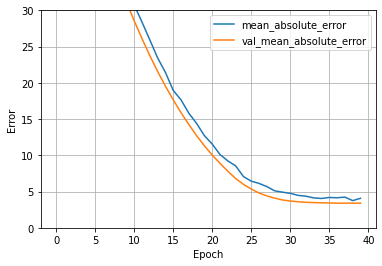

In [ ]:
plot_loss(model)



**GRU**

In [ ]:
params = {
   "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-4, #Adding Learning Rate
    "gru_units": 100,
    "epochs": 100,
    "batch_size": 8,
    "es_patience" : 0.2
}

model = get_model_GRU(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)

Epoch 1/100
19/19 [==============================] - 29s 1s/step - loss: 5914.5874 - root_mean_squared_error: 76.9063 - mean_absolute_error: 76.6468 - val_loss: 4818.8604 - val_root_mean_squared_error: 69.4180 - val_mean_absolute_error: 69.3010
Epoch 2/100
19/19 [==============================] - 21s 1s/step - loss: 4738.5547 - root_mean_squared_error: 68.8372 - mean_absolute_error: 68.7206 - val_loss: 4485.3340 - val_root_mean_squared_error: 66.9726 - val_mean_absolute_error: 66.8562
Epoch 3/100
19/19 [==============================] - 21s 1s/step - loss: 4449.2651 - root_mean_squared_error: 66.7028 - mean_absolute_error: 66.5744 - val_loss: 4209.3027 - val_root_mean_squared_error: 64.8791 - val_mean_absolute_error: 64.7589
Epoch 4/100
19/19 [==============================] - 21s 1s/step - loss: 4196.6401 - root_mean_squared_error: 64.7815 - mean_absolute_error: 64.6450 - val_loss: 3954.4192 - val_root_mean_squared_error: 62.8842 - val_mean_absolute_error: 62.7602
Epoch 5/100
19/19 [=

PLOTING THE GRU MODEL

In [ ]:
plot_loss(model)

LSTM

In [ ]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-4, 
    "lstm_units": 300,
    "epochs": 5,
    "batch_size": 8,
    "es_patience" : 0.4
}

model = get_model_LSTM(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)

Epoch 1/40
19/19 [==============================] - 35s 1s/step - loss: 4457.2744 - root_mean_squared_error: 66.7628 - mean_absolute_error: 66.1770 - val_loss: 3214.7009 - val_root_mean_squared_error: 56.6983 - val_mean_absolute_error: 56.5607
Epoch 2/40
19/19 [==============================] - 22s 1s/step - loss: 3006.3711 - root_mean_squared_error: 54.8304 - mean_absolute_error: 54.6436 - val_loss: 2591.8936 - val_root_mean_squared_error: 50.9106 - val_mean_absolute_error: 50.7574
Epoch 3/40
19/19 [==============================] - 22s 1s/step - loss: 2420.5635 - root_mean_squared_error: 49.1992 - mean_absolute_error: 49.0086 - val_loss: 2080.0015 - val_root_mean_squared_error: 45.6070 - val_mean_absolute_error: 45.4359
Epoch 4/40
19/19 [==============================] - 22s 1s/step - loss: 1972.6270 - root_mean_squared_error: 44.4143 - mean_absolute_error: 44.2091 - val_loss: 1653.8865 - val_root_mean_squared_error: 40.6680 - val_mean_absolute_error: 40.4760
Epoch 5/40
19/19 [======

PLOTTING THE LSTM MODEL

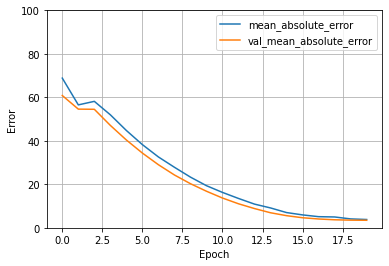

In [ ]:
plot_loss(model)

## ATTRIBUTABLE



SPLITTING THE DATA

In [ ]:
c = yAttributable
from sklearn.model_selection import train_test_split

X = d
y=  c

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=42)

BI_LSTM

In [ ]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-3, 
    "lstm_units": 200,
    "epochs": 15,
    "batch_size": 8,
    "es_patience" : 0.5
}

model = get_model_BI_LSTM(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)

Epoch 1/15
19/19 [==============================] - 190s 9s/step - loss: 1025.9557 - root_mean_squared_error: 32.0305 - mean_absolute_error: 30.6383 - val_loss: 389.0577 - val_root_mean_squared_error: 19.7245 - val_mean_absolute_error: 19.6916
Epoch 2/15
19/19 [==============================] - 165s 9s/step - loss: 269.4473 - root_mean_squared_error: 16.4149 - mean_absolute_error: 16.1974 - val_loss: 160.4995 - val_root_mean_squared_error: 12.6688 - val_mean_absolute_error: 12.6175
Epoch 3/15
19/19 [==============================] - 165s 9s/step - loss: 103.2378 - root_mean_squared_error: 10.1606 - mean_absolute_error: 9.8838 - val_loss: 52.1529 - val_root_mean_squared_error: 7.2217 - val_mean_absolute_error: 7.1312
Epoch 4/15
19/19 [==============================] - 165s 9s/step - loss: 31.9744 - root_mean_squared_error: 5.6546 - mean_absolute_error: 5.2745 - val_loss: 14.1165 - val_root_mean_squared_error: 3.7572 - val_mean_absolute_error: 3.5802
Epoch 5/15
19/19 [===================

PLOTING BI_LSTM

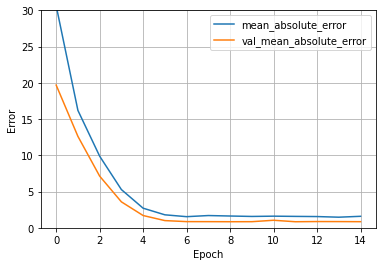

In [ ]:
plot_loss(model)

GRU

In [ ]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-4, 
    "gru_units": 200,
    "epochs": 25,
    "batch_size": 8,
    "es_patience" : 0.4
}

model = get_model_GRU(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)

Epoch 1/25
19/19 [==============================] - 83s 4s/step - loss: 1301.5013 - root_mean_squared_error: 36.0763 - mean_absolute_error: 35.2966 - val_loss: 798.5598 - val_root_mean_squared_error: 28.2588 - val_mean_absolute_error: 28.2358
Epoch 2/25
19/19 [==============================] - 74s 4s/step - loss: 701.3309 - root_mean_squared_error: 26.4827 - mean_absolute_error: 26.3581 - val_loss: 593.6296 - val_root_mean_squared_error: 24.3645 - val_mean_absolute_error: 24.3378
Epoch 3/25
19/19 [==============================] - 74s 4s/step - loss: 509.2657 - root_mean_squared_error: 22.5669 - mean_absolute_error: 22.4349 - val_loss: 431.0468 - val_root_mean_squared_error: 20.7617 - val_mean_absolute_error: 20.7304
Epoch 4/25
19/19 [==============================] - 74s 4s/step - loss: 370.4511 - root_mean_squared_error: 19.2471 - mean_absolute_error: 19.1230 - val_loss: 306.3208 - val_root_mean_squared_error: 17.5020 - val_mean_absolute_error: 17.4649
Epoch 5/25
19/19 [=============

PLOTTING THE GRU

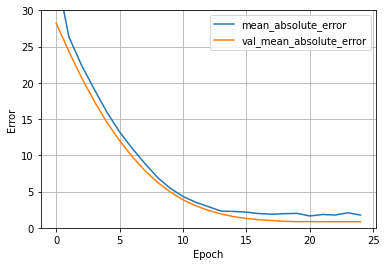

In [ ]:
plot_loss(model)

LSTM 

In [ ]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-4, 
    "lstm_units": 500,
    "epochs": 20,
    "batch_size": 8,
    "es_patience" : 0.4
}

model = get_model_LSTM(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)

Epoch 1/20
19/19 [==============================] - 147s 7s/step - loss: 703.0941 - root_mean_squared_error: 26.5159 - mean_absolute_error: 24.2841 - val_loss: 196.6904 - val_root_mean_squared_error: 14.0246 - val_mean_absolute_error: 13.9783
Epoch 2/20
19/19 [==============================] - 137s 7s/step - loss: 111.8637 - root_mean_squared_error: 10.5766 - mean_absolute_error: 10.2176 - val_loss: 41.7110 - val_root_mean_squared_error: 6.4584 - val_mean_absolute_error: 6.3570
Epoch 3/20
19/19 [==============================] - 137s 7s/step - loss: 22.6833 - root_mean_squared_error: 4.7627 - mean_absolute_error: 4.2012 - val_loss: 4.6557 - val_root_mean_squared_error: 2.1577 - val_mean_absolute_error: 1.9701
Epoch 4/20
19/19 [==============================] - 137s 7s/step - loss: 6.2206 - root_mean_squared_error: 2.4941 - mean_absolute_error: 1.5769 - val_loss: 1.3037 - val_root_mean_squared_error: 1.1418 - val_mean_absolute_error: 0.8730
Epoch 5/20
19/19 [============================

PLOTTING THE LSTM

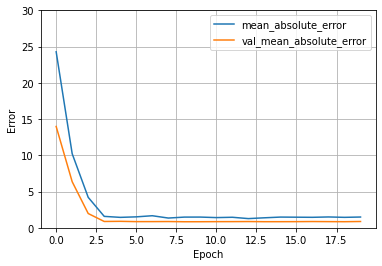

In [ ]:
plot_loss(model)

## ACCURATE



SPLITTING THE DATA

In [ ]:
c = yAccurate
from sklearn.model_selection import train_test_split

X = d
y=  c

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=42)

BI_LSTM

In [ ]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-3, 
    "lstm_units": 200,
    "epochs": 10,
    "batch_size": 8,
    "es_patience" : 0.4
}

model = get_model_BI_LSTM(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)


Epoch 1/10
19/19 [==============================] - 55s 2s/step - loss: 657.2177 - root_mean_squared_error: 25.6363 - mean_absolute_error: 23.4502 - val_loss: 124.3894 - val_root_mean_squared_error: 11.1530 - val_mean_absolute_error: 10.5555
Epoch 2/10
19/19 [==============================] - 35s 2s/step - loss: 89.3336 - root_mean_squared_error: 9.4516 - mean_absolute_error: 7.7499 - val_loss: 29.7951 - val_root_mean_squared_error: 5.4585 - val_mean_absolute_error: 4.0958
Epoch 3/10
19/19 [==============================] - 35s 2s/step - loss: 52.2009 - root_mean_squared_error: 7.2250 - mean_absolute_error: 4.1732 - val_loss: 14.5029 - val_root_mean_squared_error: 3.8083 - val_mean_absolute_error: 2.3146
Epoch 4/10
19/19 [==============================] - 35s 2s/step - loss: 49.4110 - root_mean_squared_error: 7.0293 - mean_absolute_error: 3.6666 - val_loss: 13.1222 - val_root_mean_squared_error: 3.6225 - val_mean_absolute_error: 2.2547
Epoch 5/10
19/19 [==============================] 

PLOTING BI_LSTM

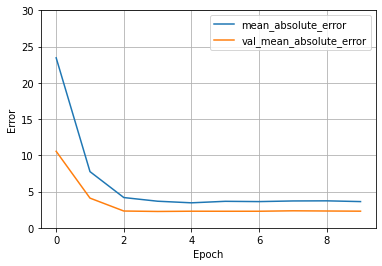

In [ ]:
plot_loss(model)

GRU

In [ ]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-3, 
    "gru_units": 400,
    "epochs": 100,
    "batch_size": 16,
    "es_patience" : 0.4
}

model = get_model_GRU(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)

Epoch 1/100
10/10 [==============================] - 97s 7s/step - loss: 734.8798 - root_mean_squared_error: 27.1087 - mean_absolute_error: 24.2885 - val_loss: 273.7710 - val_root_mean_squared_error: 16.5460 - val_mean_absolute_error: 13.5655
Epoch 2/100
10/10 [==============================] - 72s 7s/step - loss: 344.9958 - root_mean_squared_error: 18.5741 - mean_absolute_error: 13.3123 - val_loss: 930.5491 - val_root_mean_squared_error: 30.5049 - val_mean_absolute_error: 20.2897
Epoch 3/100
10/10 [==============================] - 72s 7s/step - loss: 693.7510 - root_mean_squared_error: 26.3392 - mean_absolute_error: 16.3713 - val_loss: 1393.8383 - val_root_mean_squared_error: 37.3341 - val_mean_absolute_error: 25.9886
Epoch 4/100
10/10 [==============================] - 72s 7s/step - loss: 1326.2773 - root_mean_squared_error: 36.4181 - mean_absolute_error: 25.8075 - val_loss: 1896.8634 - val_root_mean_squared_error: 43.5530 - val_mean_absolute_error: 35.4916
Epoch 5/100
10/10 [======

PLOTTING GRU

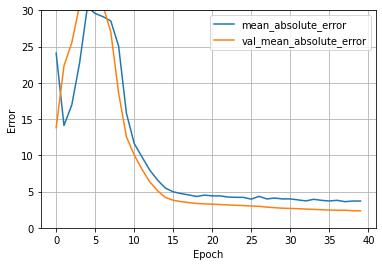

In [ ]:
plot_loss(model)

LSTM

In [ ]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-4, 
    "lstm_units": 400,
    "epochs": 20,
    "batch_size": 8,
    "es_patience" : 0.4
}

model = get_model_LSTM(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)

Epoch 1/20
19/19 [==============================] - 34s 1s/step - loss: 708.5137 - root_mean_squared_error: 26.6179 - mean_absolute_error: 23.6184 - val_loss: 799.5411 - val_root_mean_squared_error: 28.2762 - val_mean_absolute_error: 25.0123
Epoch 2/20
19/19 [==============================] - 27s 1s/step - loss: 665.3332 - root_mean_squared_error: 25.7941 - mean_absolute_error: 21.7113 - val_loss: 692.8132 - val_root_mean_squared_error: 26.3213 - val_mean_absolute_error: 23.1040
Epoch 3/20
19/19 [==============================] - 28s 1s/step - loss: 250.0495 - root_mean_squared_error: 15.8130 - mean_absolute_error: 11.2281 - val_loss: 23.7378 - val_root_mean_squared_error: 4.8722 - val_mean_absolute_error: 3.2510
Epoch 4/20
19/19 [==============================] - 28s 1s/step - loss: 50.0671 - root_mean_squared_error: 7.0758 - mean_absolute_error: 3.9687 - val_loss: 17.8639 - val_root_mean_squared_error: 4.2266 - val_mean_absolute_error: 2.9536
Epoch 5/20
19/19 [=======================

PLOTTING THE LSTM

In [ ]:
plot_loss(model)

## CONTEMPORANEOUS



SPLITING THE DATA

In [ ]:
c = yContemporaneous
from sklearn.model_selection import train_test_split

X = d
y=  c

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=42)

BI_LSTM

In [ ]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-3, 
    "lstm_units": 200,
    "epochs": 40,
    "batch_size": 8,
    "es_patience" : 0.5
}

model = get_model_BI_LSTM(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)

Epoch 1/40
19/19 [==============================] - 53s 2s/step - loss: 4878.0952 - root_mean_squared_error: 69.8434 - mean_absolute_error: 68.8769 - val_loss: 3379.6062 - val_root_mean_squared_error: 58.1344 - val_mean_absolute_error: 57.8109
Epoch 2/40
19/19 [==============================] - 35s 2s/step - loss: 2870.5688 - root_mean_squared_error: 53.5777 - mean_absolute_error: 53.1699 - val_loss: 2535.3970 - val_root_mean_squared_error: 50.3527 - val_mean_absolute_error: 49.9789
Epoch 3/40
19/19 [==============================] - 35s 2s/step - loss: 2163.7791 - root_mean_squared_error: 46.5164 - mean_absolute_error: 46.0372 - val_loss: 1883.3003 - val_root_mean_squared_error: 43.3970 - val_mean_absolute_error: 42.9627
Epoch 4/40
19/19 [==============================] - 35s 2s/step - loss: 1568.5198 - root_mean_squared_error: 39.6045 - mean_absolute_error: 38.9541 - val_loss: 1366.7028 - val_root_mean_squared_error: 36.9689 - val_mean_absolute_error: 36.4581
Epoch 5/40
19/19 [======

PLOTING BI_LSTM

In [ ]:
plot_loss(model)

GRU

In [ ]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-4, 
    "gru_units": 200,
    "epochs": 60,
    "batch_size": 8,
    "es_patience" : 0.4
}

model = get_model_GRU(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)

Epoch 1/60
19/19 [==============================] - 28s 930ms/step - loss: 5657.6235 - root_mean_squared_error: 75.2172 - mean_absolute_error: 74.5279 - val_loss: 4643.4170 - val_root_mean_squared_error: 68.1426 - val_mean_absolute_error: 67.8669
Epoch 2/60
19/19 [==============================] - 17s 877ms/step - loss: 4289.1792 - root_mean_squared_error: 65.4918 - mean_absolute_error: 65.1715 - val_loss: 4114.2178 - val_root_mean_squared_error: 64.1422 - val_mean_absolute_error: 63.8491
Epoch 3/60
19/19 [==============================] - 17s 879ms/step - loss: 3788.9277 - root_mean_squared_error: 61.5543 - mean_absolute_error: 61.2158 - val_loss: 3635.4844 - val_root_mean_squared_error: 60.2950 - val_mean_absolute_error: 59.9831
Epoch 4/60
19/19 [==============================] - 17s 875ms/step - loss: 3336.5269 - root_mean_squared_error: 57.7627 - mean_absolute_error: 57.3834 - val_loss: 3206.9817 - val_root_mean_squared_error: 56.6302 - val_mean_absolute_error: 56.2981
Epoch 5/60
1

PLOTTING GRU

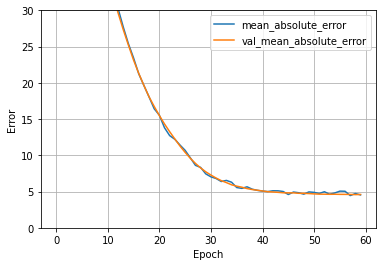

In [ ]:
plot_loss(model)

LSTM

In [ ]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "learning rate": 1e-4, 
    "lstm_units": 200,
    "epochs": 40,
    "batch_size": 8,
    "es_patience" : 0.4
}

model = get_model_LSTM(params=params, input_shape=X_train.shape[1])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

model = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1
)

Epoch 1/40
19/19 [==============================] - 26s 980ms/step - loss: 5864.5254 - root_mean_squared_error: 76.5802 - mean_absolute_error: 76.0898 - val_loss: 4837.4033 - val_root_mean_squared_error: 69.5514 - val_mean_absolute_error: 69.2813
Epoch 2/40
19/19 [==============================] - 17s 900ms/step - loss: 4448.4771 - root_mean_squared_error: 66.6969 - mean_absolute_error: 66.3737 - val_loss: 4253.6431 - val_root_mean_squared_error: 65.2200 - val_mean_absolute_error: 64.9318
Epoch 3/40
19/19 [==============================] - 17s 896ms/step - loss: 3915.3625 - root_mean_squared_error: 62.5729 - mean_absolute_error: 62.2255 - val_loss: 3767.9995 - val_root_mean_squared_error: 61.3840 - val_mean_absolute_error: 61.0778
Epoch 4/40
19/19 [==============================] - 17s 899ms/step - loss: 3462.6743 - root_mean_squared_error: 58.8445 - mean_absolute_error: 58.5039 - val_loss: 3332.7686 - val_root_mean_squared_error: 57.7301 - val_mean_absolute_error: 57.4044
Epoch 5/40
1

KeyboardInterrupt: ignored

PLOTING THE LSTM

In [ ]:
plot_loss(model)